In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("rfm_data.csv")
df

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
0,1,210,580717
1,7,140,293678
2,11,135,283712
3,97,23,281336
4,5,152,309928
...,...,...,...
62983,297,2,1134
62984,89,4,8016
62985,29,2,2594
62986,400,2,3934


# EDA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   LAST_TO_END   62988 non-null  int64
 1   FLIGHT_COUNT  62988 non-null  int64
 2   SEG_KM_SUM    62988 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [8]:
df.describe()

,LAST_TO_END,FLIGHT_COUNT,SEG_KM_SUM
count,62988.000000,62988.000000,62988.000000
mean,176.120102,11.839414,17123.878691
std,183.822223,14.049471,20960.844623
min,1.000000,2.000000,368.000000
25%,29.000000,3.000000,4747.000000
50%,108.000000,7.000000,9994.000000
75%,268.000000,15.000000,21271.250000
max,731.000000,213.000000,580717.000000


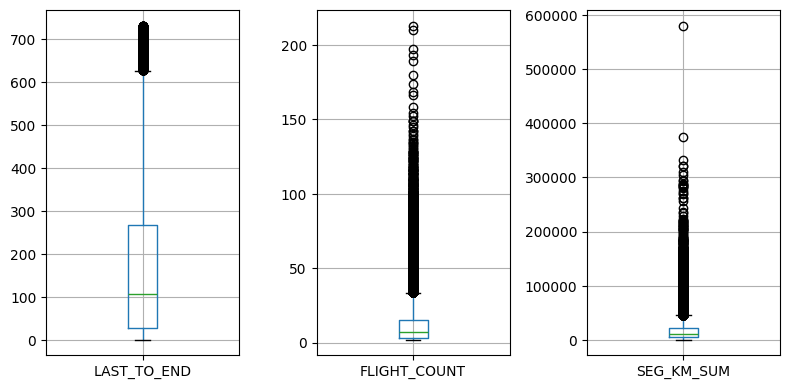

In [9]:
# Outlier Checking

list_columns = list(df.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8,4))

for i, column_name in enumerate(list_columns):
    df.boxplot(column_name, ax=ax.flatten()[i])
    

plt.tight_layout()
plt.show()

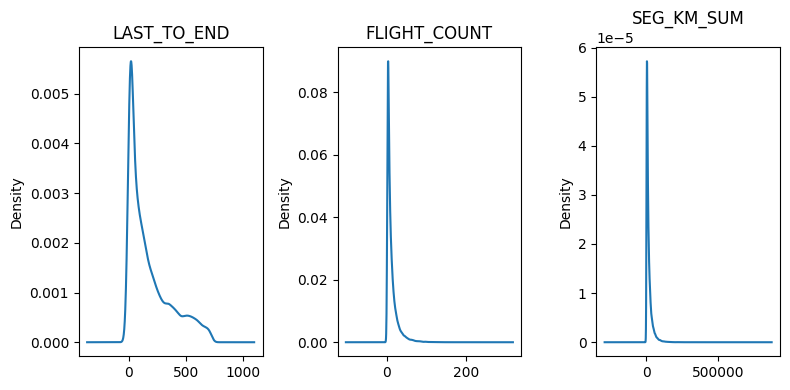

In [10]:
# Distribution of Data
 
list_columns = list(df.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8,4))

for i, column_name in enumerate(list_columns):
    df[column_name].plot(ax=ax.flatten()[i], kind='kde')
    ax.flatten()[i].set_title(column_name)

plt.tight_layout()
plt.show()

In [11]:
df.rename(columns = {'LAST_TO_END':'LAST_TO_END (R)', 'FLIGHT_COUNT':'FLIGHT_COUNT (F)', 'SEG_KM_SUM':'SEG_KM_SUM (M)'}, inplace=True)

In [12]:
df

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
0,1,210,580717
1,7,140,293678
2,11,135,283712
3,97,23,281336
4,5,152,309928
...,...,...,...
62983,297,2,1134
62984,89,4,8016
62985,29,2,2594
62986,400,2,3934


# Data Pre-processing 

In [13]:
df.corr()

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
LAST_TO_END (R),1.000000,-0.404999,-0.369509
FLIGHT_COUNT (F),-0.404999,1.000000,0.850411
SEG_KM_SUM (M),-0.369509,0.850411,1.000000


In [14]:
from sklearn.preprocessing import QuantileTransformer

quantile_trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
df_scaled = quantile_trans.fit_transform(df)

In [15]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

,LAST_TO_END (R),FLIGHT_COUNT (F),SEG_KM_SUM (M)
0,-5.199338,5.199338,5.199338
1,-1.368450,3.224915,3.169536
2,-1.154615,3.185427,3.159604
3,-0.050204,1.097845,3.157281
4,-1.525529,3.347528,3.186433
...,...,...,...
62983,0.761353,-5.199338,-2.456904
62984,-0.092972,-0.480839,-0.183324
62985,-0.668987,-5.199338,-1.366054
62986,1.061884,-5.199338,-0.875354


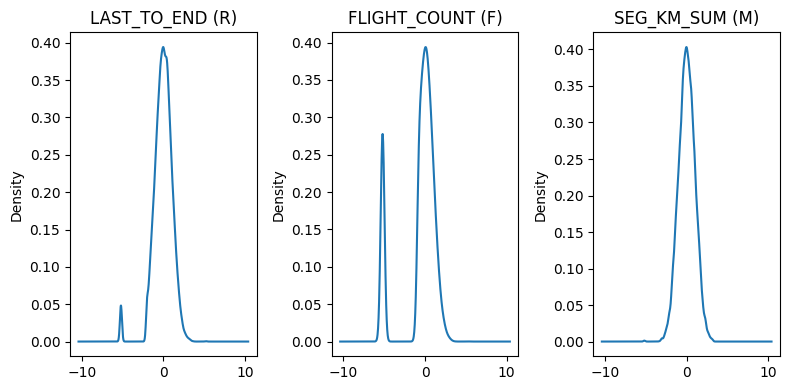

In [16]:
list_columns = list(df_scaled.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8,4))

for i, column_name in enumerate(list_columns):
    df_scaled[column_name].plot(ax=ax.flatten()[i], kind='kde')
    ax.flatten()[i].set_title(column_name)

plt.tight_layout()
plt.show()

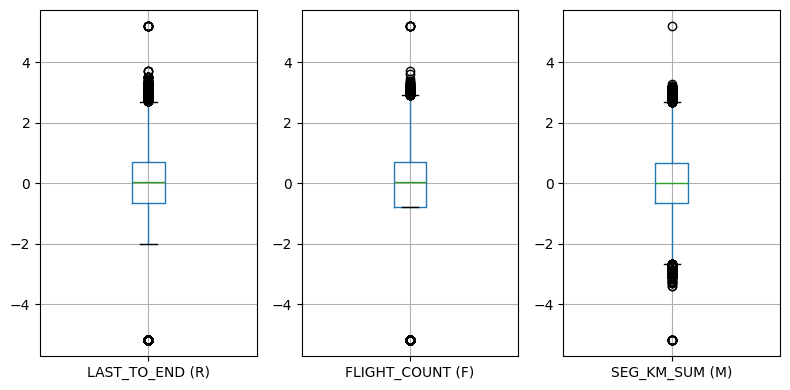

In [17]:
list_columns = list(df_scaled.columns.values)

num_rows = 1
num_cols = 3

fig, ax = plt.subplots(num_rows, num_cols, figsize=(8, 4))

for i, column_name in enumerate(list_columns):
    df_scaled.boxplot(column_name, ax=ax.flatten()[i])

plt.tight_layout()
plt.show()

In [18]:
# Outlier Persentation

for i, j in df_scaled.items():
    q1 = j.quantile(0.25)
    q3 = j.quantile(0.75)
    inter_q = q3 - q1

    j_col = j[(j <= q1 - 1.5 * inter_q) | (j >= q3 + 1.5 * inter_q)]
    percent = np.shape(j_col)[0] * 100.0 / np.shape(df)[0]
    print("Column %s outliers = %.2f" %(i, percent))

Column LAST_TO_END (R) outliers = 1.90
Column FLIGHT_COUNT (F) outliers = 16.65
Column SEG_KM_SUM (M) outliers = 0.63


# Trimmed K-MEANS

In [1]:
import sys
sys.path.append("../RTKM")
from RTKM import * 
from AccuracyMeasures import *
from ClusteringMeasures import *

#pip install regmod
#pip install wheel
#pip install proxlib==0.0.1

df_scaled_np = df_scaled.to_numpy()
RTKM_data = RTKM(df_scaled)
RTKM_data.perform_clustering(k=2, percent_outliers = 0.10, max_iter = 100, num_members = 2)
pred_clusters, pred_outliers = RTKM_data.return_clusters()

# tp, fp, tn, fn, f1_scores, me = accuracy_measures(true_clusters = true_labels.T, pred_clusters = RTKM_yeast.weights, pred_outliers = RTKM_yeast.outliers, membership_option = 'multi')

# print('\n\n Number of true positives: ', tp, '\n\n Number of false positives : ', fp, 
#       '\n\n Number of true negatives: ', tn, '\n\n Number of false negatives: ', fn, 
#       '\n\n F1 scores for each cluster: ', f1_scores, '\n\n Average F1 score: ', np.average(f1_scores),
#      '\n\n me score:', me)

# plt.figure()
# plt.scatter(Xnew[0,:], Xnew[1,:])
# plt.scatter(Xnew[0,pred_outliers], Xnew[1,pred_outliers], c = 'r', label = 'Identified outliers')
# plt.legend()
# plt.title('Robust Trimmed k Means')

OSError: octave not found, please see README